# Advanced Hovmoller plot from user supplied vector


This notebook demonstrates how to open a polyline vector file (.shp format) and generate a Hovmoller plot of NDVI for that polyline

In [1]:
%pylab notebook
from __future__ import print_function
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.helpers import ga_pq_fuser
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio

Populating the interactive namespace from numpy and matplotlib


In [2]:
dc = datacube.Datacube(app='dc-Hovmoller polyline example')

In [3]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist]))
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [4]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Select polyline, replacing /g/... with /*your_path_here*/your_file.shp

vec_fname = 'shapefiles/08_Example.shp' 

with fiona.open(vec_fname) as src:
    geom = shape(src[0]['geometry'])

#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensors  = ['ls8','ls7','ls5']

query = {'time': (start_of_epoch, end_of_epoch),}
query.update(geom_query(geom)) 
query['crs'] = 'EPSG:4326'

In [5]:
print(query)

{'time': ('1987-01-01', '2016-12-31'), 'x': (131.7175534943407, 131.7401980072273), 'y': (-12.34156590969777, -12.27136045497673), 'crs': 'EPSG:4326'}


In [6]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensors[0]+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']


In [7]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [8]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', fuse_func=ga_pq_fuser, **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

In [9]:
#Concatenate the data from different sensors together and sort by time
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

#Extract the hovmoller data volume
geom_w = warp_geometry(geom, query['crs'], crs.wkt)
hov = transect(nbar_clean, geom_w, 25)

## Plotting an image, view the transect and select a location to retrieve a time series

In [10]:
print('The number of time slices at this location is '+ str(nbar_clean.red.shape[0]))

The number of time slices at this location is 795


In [11]:
#select time slice of interest - this is trial and error until you get a decent image
time_slice_i = 550
rgb = nbar_clean.isel(time =time_slice_i).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


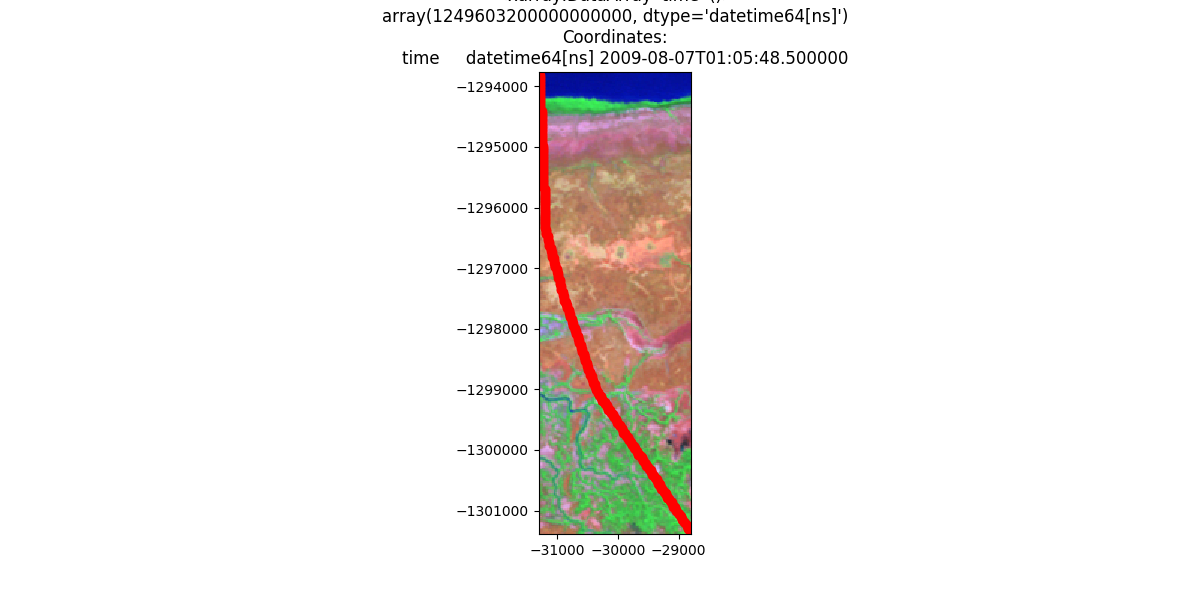

In [12]:
#View the polyline vector on the imagery
fig = plt.figure(figsize =(12,6))
plt.scatter(x=hov.coords['x'], y=hov.coords['y'], c='r') #turn this on or off to show location of transect
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

date_ = nbar_clean.time[time_slice_i]
plt.title(date_.astype('datetime64[D]'))
plt.show()

### View a hovmoller plot for the transect

<IPython.core.display.Javascript object>


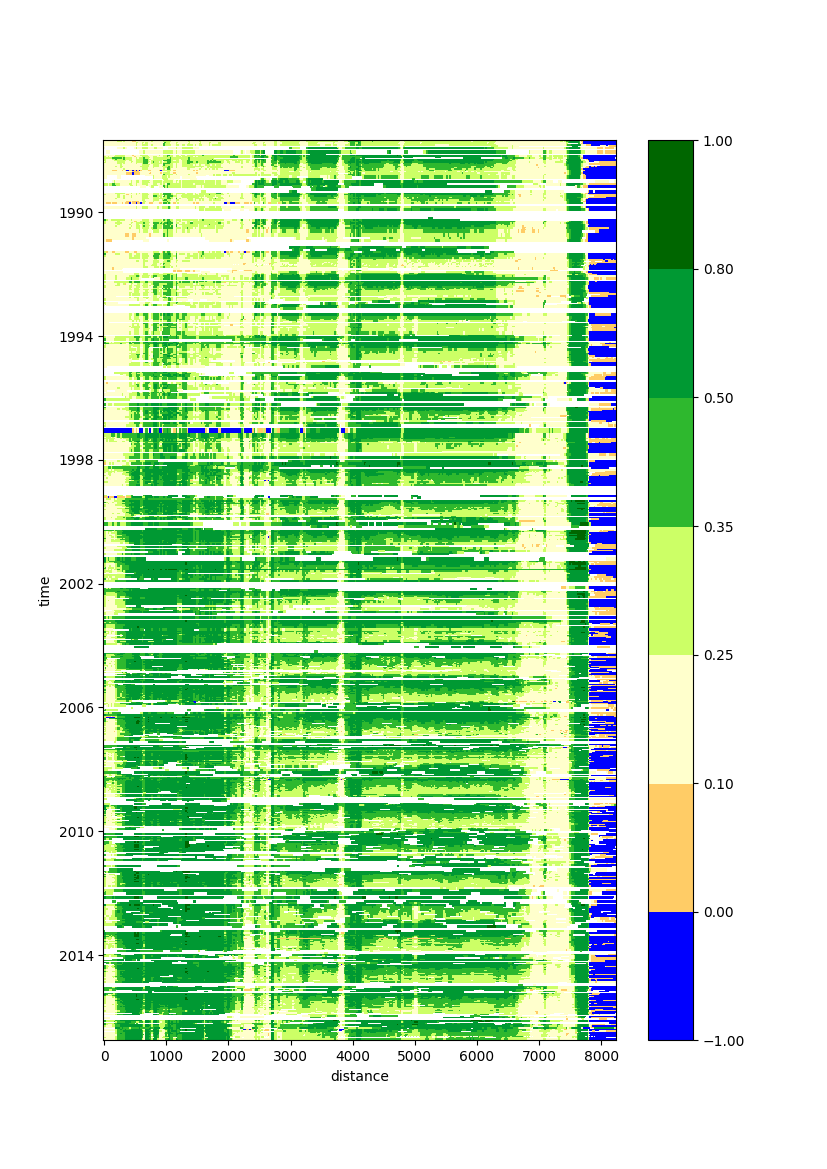

In [13]:
#Calculate NDVI
hov_ndvi = ((hov.nir-hov.red)/(hov.nir+hov.red))

#Set up an NDVI colour ramp 
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

#Generate the Hovmoller plot
fig = plt.figure(figsize=(8.27,11.69))
hov_ndvi.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)

<IPython.core.display.Javascript object>


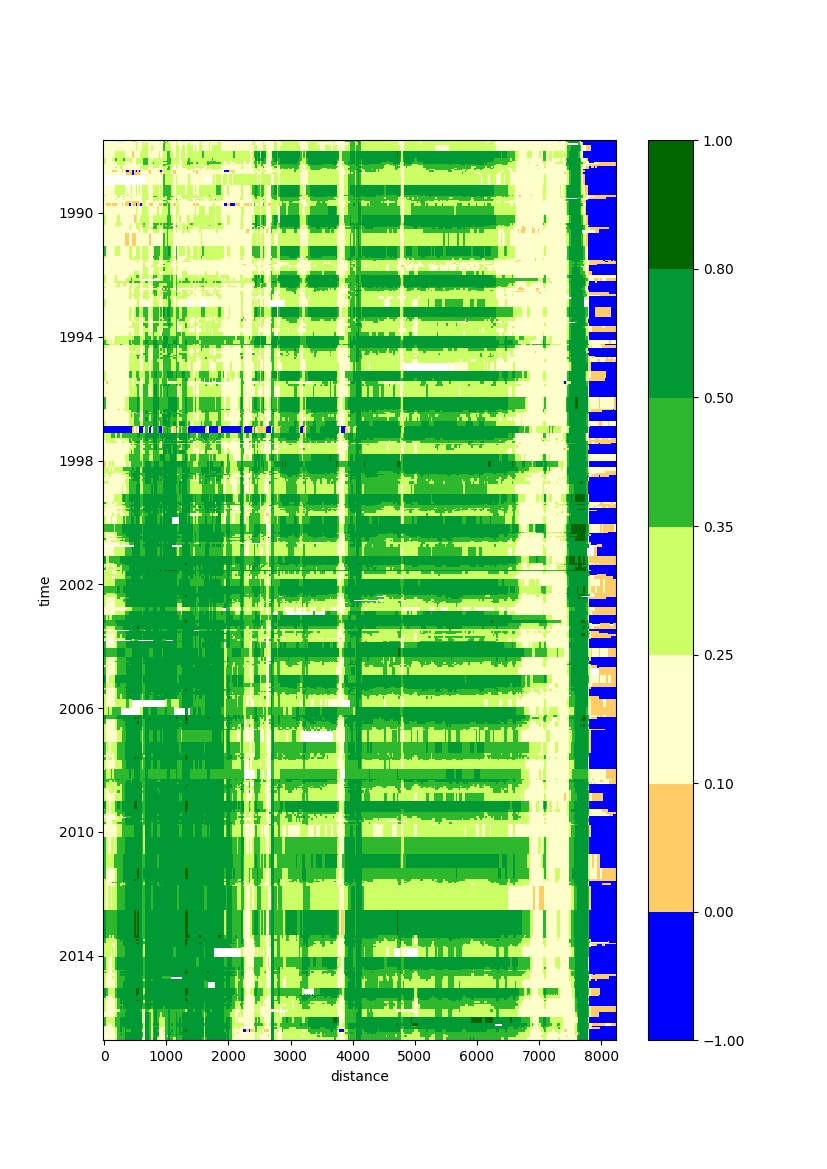

In [14]:
# You'll notice that there are some rows that contain very few observations and make the plot harder to interpret
# Set the percentage of good data that you'd like to display with pernan variable - 0.9 will return rows that have 90%
# of valid values

pernan = 0.9
hov_ndvi_drop = hov_ndvi.dropna('time',  thresh = int(pernan*hov.distance.size))
fig = plt.figure(figsize=(8.27,11.69))
hov_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)

In [15]:
#You can check below to see the number of time slices dropped
print('The number of time slices unfiltered = '+ str(hov_ndvi.time.size))
print('The number of time slices filtered = ' + str(hov_ndvi_drop.time.size))

The number of time slices unfiltered = 795
The number of time slices filtered = 269


<IPython.core.display.Javascript object>


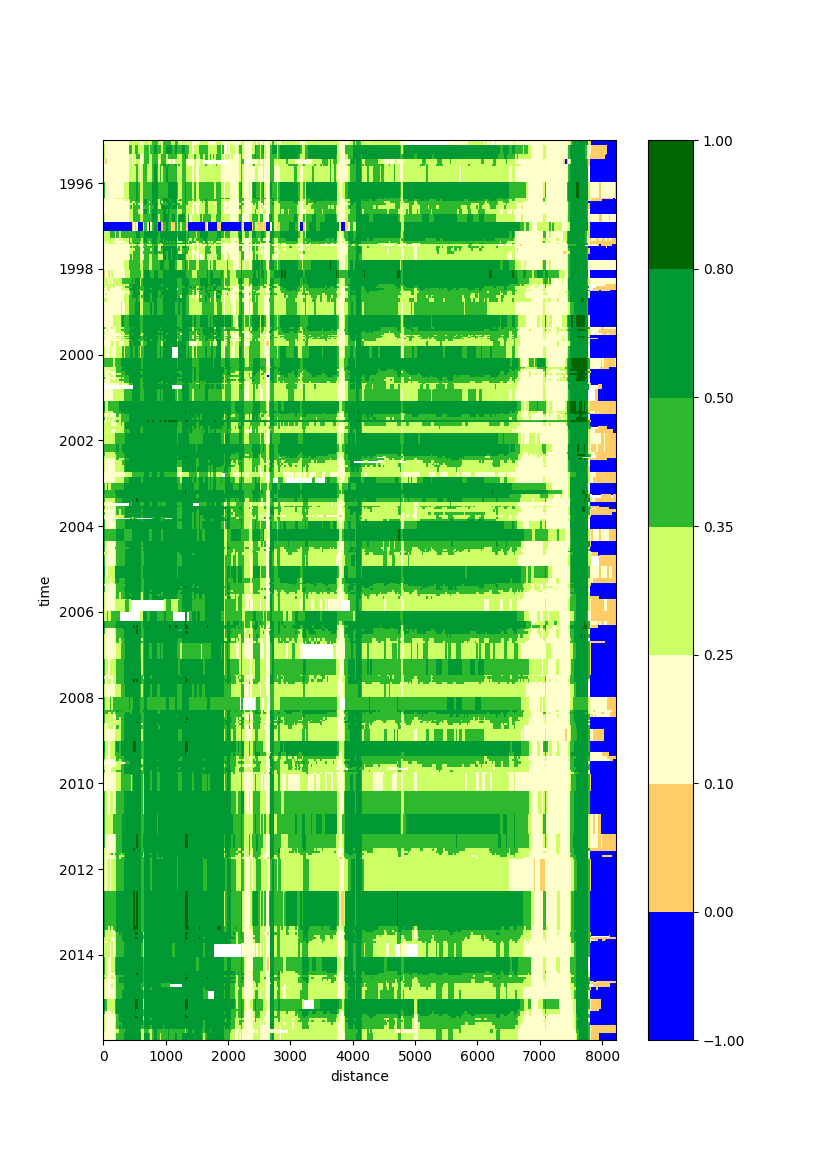

[0, <xarray.DataArray 'distance' ()>
 array(8225), '2015-12-31', '1995-01-01']

In [16]:
#Use firstyear and lastyear to zoom into periods of interest
firstyearhov = '1995-01-01'
lastyearhov = '2015-12-31'
fig = plt.figure(figsize=(8.27,11.69))
hov_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)
plt.axis([0, hov_ndvi_drop.distance.max(), lastyearhov , firstyearhov])
